## Questions:

### thinking about optimal model parameters vs. making the model realistic:

Should generations overlap?
Should parent pairs produce 2 offspring or one?

We are doing **single-point** crossover.
We could also do **double-point** (two  segmentations) or **uniform** (each gene is independent) crossover.

We are using **probibalistic tournament selection** with 3 random competitors vying to be parents (based on fitness)
We could also use **deterministic5 tournament selection**
We could also use **fitness proportionate selection**, which is tournament selection among a whole group
We could choose fathers (or mothers) using one of these methods, and then choose from among that agent's mates

## Socioecological variables to review

Degree of synchrony
Degree of skew

Coding genes as parameters of a (e.g. gamma) dist

# Import packages



In [132]:
import random as rd
import math
import statistics
import numpy as np
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import array as nparray
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain

# Evolving Model object

The class "evolvingModel" contains class variables and methods to initialize a simulated world with multiple groups and simulate biological evolution using a genetic algorithm. Initialization sets the model to generation 0 and instantiates **nGroups** social groups of class "group."

The ***evolve*** method of class "evolvingModel" loops through **nGenerations** generations. ***Evolve*** method process: First, the generation number is increased by 1. Then, the behavior of each group is simulated for a single generation using the ***runModel*** method of class "group." The ***setupNextGen*** and ***setGenotypes*** methods of class "group" then decides on a cohort of **nAgents** mothers and **nAgents** fathers for the next generation, perform  genetic **recombination** using mothers' and fathers' genes, performs probabilistic **mutation** of offspring genes, and finally initializes a new generation of **nFemales** and **nMales** with the those genes. Finally, the ***migration*** method of class "evolvingModel" probabilistically selects some number of the next gerenations' agents to migrate to new groups, based on parameter **migrationRate**, with a probability of **maleDispersalBias** that the agent selected for migration with be male. Migration switches the following class variables of the agent (a member of either class "female" or "male") : **"genes", "signalList"** (females only), and **"cost"**.

If **realTimePlots** is set to True, a dot plot of average signal strengh (Y-axis) across group 0 against cycle day (X-axis) appears in a quartz window following the first generation and updates with probability **realTimePlotsRate** for future generations. Following a model run of **nGenerations**, a line plot showing changes across generations in the intra-generation variability of cycle days on which the alpha male of group 0 mates, with lines for first quartile, median, and 3rd quartile of mating days. The Y-axis is mating days and the X-axis is generations. This concludes the model run.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables


In [182]:
class evolvingModel:
    
    def __init__(self):
        
        self.generation = 0
        
        self.groups = []
        
        for g in range(nGroups):
            self.groups.append(group(g))

        self.alphaMates, self.alphaMatingSpread = [], [[],[],[]]
        
        self.alphaMates, self.alphaMatingMedian,  self.alphaMating1Q, self.alphaMating3Q = [], [], [], []
        
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * nAgents * nGroups * nGenerations)
        self.potentialDads = rdchoices(range(nMales), k = 3 * nAgents * nGroups * nGenerations)
        
        self.genesInGroup = nAgents * cycleLength
        self.mutations = [round(uniform(0,genesInGroup * mutationRate * 2)) for i in range(nGenerations + 1)]
        
    def evolve(self):
          
        if realTimePlots == True:
            %matplotlib qt
        
        while self.generation < nGenerations:
            self.generation += 1
            
            g = 0
            while g < nGroups:
                self.groups[g].runModel() 
                g += 1
        
            if realTimePlots == True and (rd.uniform(0,1) < realTimePlotsRate or self.generation == 1):
                self.plotSignal() if whichPlot == "Signal" else self.plotPairs()
            elif rd.uniform(0,1) > 0.99:
                print(self.generation)
            
            #self.updateAlphaMatingDays()
            
            if self.generation == nGenerations - 1:
                %matplotlib inline
                self.plotRS()
               
            for g in self.groups:
                g.setupNextGen()
                g.setGenotypes()
               
            if dispersal == True:
                self.migration()
        
        if realTimePlots == False:
            self.plotSignal()
            self.plotPairs()
            
        #self.plotMatingDays()
            
    def migration(self):
                
        migrations = round(normal(totalAgents * mutationRate))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost
        
    def plotSignal(self):

        lst = []
        lstLower = []
        lstUpper =[]
        for j in range(cycleLength):
            lst.append(statistics.mean([f.signalList[j] for f in sum([g.females for g in model.groups], [])]))
            SEM = scipy.stats.tstd([f.signalList[j] for f in sum([g.females for g in model.groups], [])])
            lstLower.append(lst[j] - SEM) if SEM < lst[j] else lstLower.append(0)
            lstUpper.append(lst[j] + SEM)

        if rd.choice([1,2]) == 1:
            plt.clf()
            plt.plot(lst, "bo")
            plt.plot(lstLower, "r")
            plt.plot(lstUpper, "r")
            plt.ylim = [0,max(lst) * 1.1]
            plt.text(0.1, max(lst) * 0.9, str(self.generation))
            plt.pause(0.000001)
            plt.show()
            
    def plotRS(self):
        
        femaleRS = [f.reproductiveSuccess for f in model.groups[0].females]
        maleRS = [m.reproductiveSuccess for m in model.groups[0].males]
        
        print("SD^2 in female RS:"+str(statistics.variance(femaleRS)))
        print("SD^2 in male RS:"+str(statistics.variance(maleRS)))

        plt.figure()
        plt.hist(maleRS, alpha=0.5, label = "male RS")
        plt.hist(femaleRS, alpha=0.5, label = "female RS")
        plt.title('Male and female Reproductive Success')
        plt.legend(loc='upper right')
        plt.show()
        
        plt.figure()
        plt.plot([m.rank for m in model.groups[0].males],
                 [m.reproductiveSuccess for m in model.groups[0].males], 'bo')
        plt.title('male RS ~ rank')
        plt.show()
        
    def plotMatingDays(self):
        
        plt.figure()
        
        for i in range(3):
            plt.plot(range(self.generation), self.alphaMatingSpread[i])
        
        plt.ylim = [0, cycleLength]
        plt.xlim = [0, 1.0]
        plt.title("Synchrony: " + str(round(synchrony, 2)) + "; Rank/Fitness Correlation: " + str((rankCor, 2)))
        
    def updateAlphaMatingDays(self):
    
        self.alphaMates.extend(self.groups[0].males[0].mateTiming)
        a,b,c = np.percentile(self.alphaMates,[25, 5, 75])

        self.alphaMatingSpread[0].append(a)
        self.alphaMatingSpread[1].append(b)
        self.alphaMatingSpread[2].append(c)
        
    def plotPairs(self):
        plt.clf()
        plotGroup = model.groups[0]
        plotGroup.females = sorted(np.random.choice(plotGroup.females, size=nFemales, replace=False), key=plotGroup.sortSignal)
        signals = [f.signal * 1000 for f in plotGroup.females]
        IDs = [f.ID for f in plotGroup.females]
        plt.scatter([1] * nFemales, [f.ID for f in plotGroup.females], s = signals)
        plt.scatter([2] * nMales, [m.rank for m in plotGroup.males], s = [m.rank for m in plotGroup.males])
        plt.scatter(0,0, s = 0)
        plt.scatter(3,0, s = 0)
        mates = [[plotGroup.females[i].ID] + [plotGroup.males[i].rank] for i in range(nPairs)]
        mates = [agent for pair in mates for agent in pair]
        for i in range(nPairs):
            plt.plot([1,2],[plotGroup.females[i].ID, plotGroup.males[i].rank],linewidth=0.5)
        plt.xlim = [0,3]
        plt.text(0.1, nMales * 0.9, str(model.generation))
        plt.title('mating pairs based on female signal size (left)\nand male rank (right)')
        plt.pause(0.00001)
        plt.show()
        

# Group object

The class "group" generates and simulates the behavior of a single population over the course of a mating season. At initialization, the **"run"** boolean variable is set to "True" and **"step"**, which keeps count of timesteps (days) of the simulation, is set to 0. The ***setFitness*** method then sets up a list of male fitness values (**"fitnessList"**) that is correlated to male ranks with a correlation coefficient of approximately **rankCor**. Finally, **nFemales** objects of class "female" and **nMales** objects of class "male" are instantiated in lists (**"males"** and **"females"**) contained in the "group" object.

The ***runModel*** method simulates agent behavior for **modelLength** timesteps (days). It first calls the **makeMatingPairs** method, which orders "male" and "female" objects by **"rank"** and **"signal"**, respctively. Mating pairs are created by pairing males and females with the same index in their respective ordered lists. Males then receive an increase to their **"reproductiveSuccess"** variable in the amount of the current **"conceptionProbability"** of their mate, and females receive an increase to their **"reproductiveSuccess"** variable in the amount of their current **"conceptionProbability"** multipled by the **"fitness"** of their mate.

For each "female" object, the ***setupCycleDay*** method of class "female" is run to 1) increase **"cycleDay"** by one, and set **"signal"** and **"conceptionProbability"** based on the unique **"signalList"** associating that "female's" **"cycleDay"** and **"signal"** strength variables, and the global **conceptionProbabilityList**, which associates **"cycleDay"** with **"conceptionProbability"**.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

21
76
124
151
322
612
672
961
SD^2 in female RS:0.031249792327006278
SD^2 in male RS:0.4485660190784411


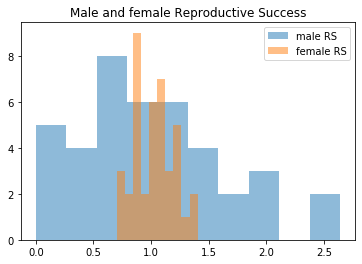

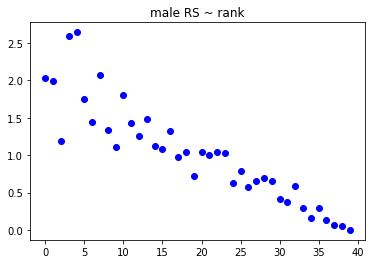

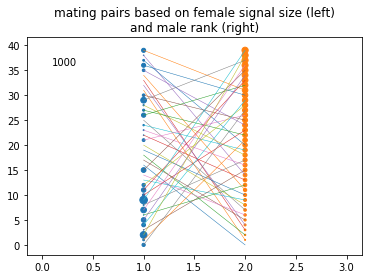

         23264213 function calls (23188941 primitive calls) in 74.818 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   300000   21.749    0.000   21.749    0.000 <ipython-input-192-5ffbe4bf3160>:54(makeMatingPairs)
   300000   18.691    0.000   18.691    0.000 <ipython-input-192-5ffbe4bf3160>:43(setupCycleDay)
     5000    8.111    0.002   55.311    0.011 <ipython-input-192-5ffbe4bf3160>:23(runModel)
   300684    5.012    0.000    6.474    0.000 {built-in method builtins.sorted}
   800000    3.020    0.000    4.672    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/random.py:344(choices)
     5000    1.775    0.000    4.309    0.001 <ipython-input-192-5ffbe4bf3160>:85(<listcomp>)
     5000    1.724    0.000    4.183    0.001 <ipython-input-192-5ffbe4bf3160>:88(<listcomp>)
 12000040    1.462    0.000    1.462    0.000 <ipython-input-192-5ffbe4bf3160>:51(sortSignal)
     5000    1.357    0.000    2.694    0.001 <ip

      667    0.002    0.000    0.032    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1470(transform_point)
     1320    0.002    0.000    0.012    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2470(composite_transform_factory)
     1866    0.002    0.000    0.002    0.000 {built-in method builtins.max}
     1808    0.002    0.000    0.004    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/lines.py:1282(set_xdata)
      197    0.002    0.000    0.019    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:2264(isclose)
      117    0.002    0.000    0.037    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:164(draw_text)
     7935    0.002    0.000    0.002    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:273

      123    0.001    0.000    0.007    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/lines.py:1327(update_from)
      301    0.001    0.000    0.002    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/path.py:159(_fast_from_codes_and_verts)
       98    0.001    0.000    0.016    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:442(_get_text2)
       95    0.001    0.000    0.027    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:588(_get_tick2line)
       42    0.001    0.000    0.012    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:332(_apply_params)
     1623    0.001    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1136(set_text)
   186/73    0.001    0.000    0.009    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/si

  796/772    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/spines.py:208(_ensure_position_is_set)
      395    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py:526(get)
       65    0.000    0.000    0.019    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/patches.py:588(get_window_extent)
        1    0.000    0.000    0.556    0.556 <ipython-input-182-146297fc0936>:144(plotPairs)
      272    0.000    0.000    0.016    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:280(__array__)
      348    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py:608(_column_stack_dispatcher)
     1640    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_man

       23    0.000    0.000    0.002    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:1446(apply_aspect)
      699    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
        3    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/gridspec.py:86(get_grid_positions)
       53    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/offsetbox.py:94(_get_aligned_offsets)
      197    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_ufunc_config.py:429(__init__)
      268    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:1324(make_mask_descr)
       41    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/patches.py:375(set_li

       50    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/threading.py:1050(_wait_for_tstate_lock)
        3    0.000    0.000    0.007    0.002 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:94(publish)
      110    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/shape_base.py:219(_vhstack_dispatcher)
       50    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(diff)
       37    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:287(x0)
       64    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:1648(__call__)
       34    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/numbers.py:283(__float__)
      256    0.000    0.000    0.000    0.000 /Users/kevi

        3    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/hmac.py:117(_current)
        2    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:228(nanmin)
        6    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:150(__init__)
       15    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/offsetbox.py:189(get_offset)
        5    0.000    0.000    0.007    0.001 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/offsetbox.py:239(get_window_extent)
        3    0.000    0.000    0.004    0.001 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:942(_gen_axes_spines)
        9    0.000    0.000    0.001    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/m

        4    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/path.py:438(transformed)
        9    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:886(x0)
        6    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:1603(__init__)
        6    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:2093(__init__)
        7    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:1254(__init__)
        4    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:2137(_convert_dx)
        4    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/si

        3    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/jupyter_client/session.py:236(msg_header)
        2    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/fractions.py:588(_richcmp)
        2    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3148(size)
       12    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:112(isComplexType)
        6    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:125(_realType)
        6    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:193(_assert_stacked_2d)
        3    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/matp

       17    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/inspect.py:2529(kind)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/inspect.py:2829(from_callable)
        2    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/inspect.py:2835(parameters)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/argparse.py:873(__call__)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/argparse.py:1226(__init__)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/argparse.py:1740(_get_positional_actions)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/argparse.py:1748(parse_args)
        1    0.000    0.000    0.000    0.000 /Users/kevinrosenfield/opt/anaconda3/lib/python3.7/argparse.py:2102(_p

In [193]:
import cProfile, pstats
model = evolvingModel()
profiler = cProfile.Profile()
profiler.enable()
model.evolve()
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats()

In [192]:
class group:
    
    def __init__(self, g):
        
        self.ID = g
        self.step = 0
        
        #start = time.time()
        self.setFitness()
        self.cycleDayList = randint(0, round((cycleLength - 1) * (1 - synchrony)), size = nFemales)
        #print(time.time() - start)
        
        self.males, self.females = [], []
        
        #start = time.time()
        for m in range(nMales):
            self.males.append(Male(m, self.fitnessList[m]))

        for f in range(nFemales):
            self.females.append(Female(f, self.cycleDayList[f]))
        #print(time.time() - start)
        
    def runModel(self):

        self.tieBreaker = uniform(0,0.00000000001, nFemales * modelLength)
        while self.step < modelLength:

            self.females = sorted(self.females, key=self.sortSignal)
            self.makeMatingPairs()
            self.setupCycleDay()
            
            i = 0
            while i < nFemales:
                self.females[i].signal = self.tieBreaker[self.step * nFemales + i]
                i += 1

            self.step += 1
            
            '''
            elif self.step == modelLength / 2:
                print(self.step)
            '''   
    def setupCycleDay(self):
        self.cycleDayList += 1
        self.cycleDayList[self.cycleDayList == 31] = 1
        for f in self.females:
            f.cycleDay = self.cycleDayList[f.ID]
            f.signal = f.signalList[f.cycleDay - 1]
            f.conceptionProbability = conceptionProbabilityList[f.cycleDay - 1]
    
    def sortSignal(self, f):
        return f.signal

    def makeMatingPairs(self):
        i = 0
        while i < nPairs:
            f = nFemales - 1 - i
            self.males[i].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            #self.males[i].mateTiming.append(self.females[f].cycleDay)
            self.females[f].reproductiveSuccess += self.females[f].conceptionProbability * self.males[i].fitness
            i += 1
        
    def setFitness(self):

        fitnessList = ranks
        i = 0.5
        while abs(0 - rankCor + corrcoef(ranks, fitnessList)[1,0]) > 0.05:
            fitnessList += [rduniform(-i,i) for f in range(len(fitnessList))]
            i += 0.05
            i = 0.5 if i == 10 else i
            
        self.fitnessList = flip((fitnessList - np.min(fitnessList))/np.ptp(fitnessList))
            
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess - f.cost for f in self.females]
        # lack of ability to chose becomes a cost as rankCor goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = [m.reproductiveSuccess for m in self.males] # does male fitness matter?
            
        parentsStartingPoint = model.generation * nGroups * nAgents + self.ID * nAgents    
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (nAgents * 3), 3)]
        dads = [rdchoices(model.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (nAgents * 3), 3)]
            
        self.nextGenMotherGenes = [self.females[m].genes for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes for d in dads]

        self.recombination()
        self.mutation()
        self.reset()
            
    def recombination(self):
        
        self.offspringGenes = []
        recombinationPoints = choice(range(cycleLength), nAgents)
        splitTypes = randint(0,2, nAgents)
        i = 0
        while i < nAgents:
            recombinationPoint = recombinationPoints[i]
            if splitTypes[i] == 1:
                self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
                                           [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
            else:
                self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
                                           [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
            i += 1
                
    def mutation(self):
        
        genesInGroup = nAgents * cycleLength
        mutations = model.mutations[model.generation]
        genesMutating = choice(range(cycleLength), mutations)
        offspringsMutating = choice(range(len(self.offspringGenes)), mutations)
        pertubations = uniform(-0.02,0.02, mutations)
        newGenes = nparray([self.offspringGenes[offspringsMutating[m]][genesMutating[m]] + pertubations[m] for m in range(mutations)])
        newGenes[newGenes < 0] = 0
        for m in range(mutations):
            self.offspringGenes[offspringsMutating[m]][genesMutating[m]] = newGenes[m]
            
    def setGenotypes(self):
        
        for f in self.females:
            f.genes = self.offspringGenes[f.ID]
            f.cost = sum(self.offspringGenes[f.ID])
            f.signalList = f.genes
            f.setupCycleDay()

        for m in self.males:
            m.genes = self.offspringGenes[m.rank + nFemales]
            
    def reset(self):
        self.step = 0
        self.setFitness()
        self.cycleDayList = randint(0, round((cycleLength - 1) * (1 - synchrony)), size = nFemales)
        self.males, self.females = [], []
        self.males = [Male(m, self.fitnessList[m]) for m in range(nMales)]
        self.females = [Female(f, self.cycleDayList[f]) for f in range(nFemales)]
            

[0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.135, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


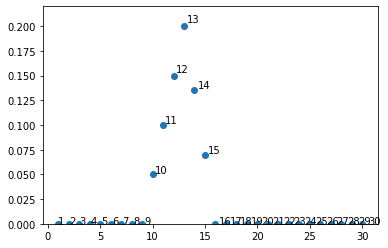

In [852]:
inceraseStartDay = 9
increaseDuration = 4
decreaseStartDay = inceraseStartDay + increaseDuration
increaseCoefficient = 0.05
totalIncrease = increaseDuration * increaseCoefficient
decreaseCoefficient = 0.065

x =  np.arange(1,cycleLength + 1,1)
y = [0] * (inceraseStartDay - 1) + [0 + increaseCoefficient * i for i in range(increaseDuration+1)]
y = y + [(totalIncrease) - i * decreaseCoefficient for i in range(1,int(totalIncrease/decreaseCoefficient))]
y = y + [0] * (cycleLength - len(y))
print(y)
fig , ax = plt.subplots()
ax.scatter(x,y)
ax.set_ylim(0,max(y)*1.1)
for i, txt in enumerate(x):
    ax.annotate(txt, (x[i]*1.02, y[i]*1.02))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05784435, 0.16082819, 0.19820558, 0.25408223, 0.24362408, 0.10373275, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


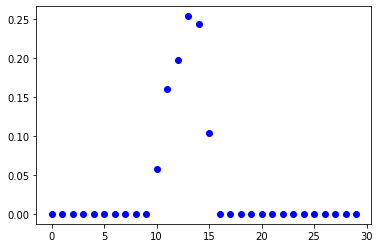

In [853]:
print(conceptionProbabilityList)
plt.plot(conceptionProbabilityList,'bo')

# Male object

Calling the class "male" instantiates a "male" object with the following class variables representing its behavioral and biological traits:

**"rank"** represents the agent's position in mating competition; the **makeMatingPairs** method of class "group" matches males of lower numerical **"rank"** (higher dominance) with females of higher **"signal"**  for mating.

**"fitness"** is correlated with **"rank"** with a correlation coefficient of approximately **rankCor** and influences the chances that mating will result in surviving offspring when it is multiplied by **"conceptionRisk"** to determine **"reproductiveSuccess"**.

**"reproductiveSuccess"** results from mating with fertile females and through the **setupNextGen** method of class "group" and determines which males wil produce offspring to populate the next generation.

**"mateTiming"** indicates the **"cycleDay"** on which mating occurred (for visualiztion purposes only)

**"startingSignal"** indicates how the fertility signal **"genes"** will be distributed at the start of the model run. Because males do not signal, this does not affect their behavior during th model, but can influence that of their female offspring.

**"genes"** determine signal strength and are passed on to offspring. They only influence female behavior.

**"cost"** of signaling only influences female reproduction.

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [4]:
class Male:
    
    __slots__ = 'rank', 'fitness', 'reproductiveSuccess',  'genes', 'cost', 'mateTiming'
    
    def __init__(self, m, fitness):
        self.rank = m
        self.fitness = fitness
        self.reproductiveSuccess = 0
        self.mateTiming = []
        if startingSignal == "noSignal":
            self.genes = [0] * cycleLength
        elif startingSignal == "randomUniform":
            self.genes = np.random.uniform(0,1, cycleLength)
        self.cost = 0
        

# Female object

Calling the class "female" instantiates a "female" object with the following class variables representing its behavioral and biological traits:

**"ID"** helps locate the agent's index in lists

**"cycleDay"** determines the day of the cycle on which females start the model. High cycle **synchrony** constrains  it to fewer days

**"reproductiveSuccess"** results from mating with fit males and through the **setupNextGen** method of class "group" and determines which females will produce offspring to populate the next generation.

**"startingSignal"** indicates how the fertility signal **"genes"** will be distributed at the start of the model run.

**"genes"** determine signal strength and are passed on to offspring

**"cost"** of signaling is calculated by adding absolute daily signal strengths and daily increases in signal strength

Key: \
"Quotation marks" indicates a class \
**bold** indicates global variables \
***bold, italicized*** indicates methods \
**"bold, in quotation marks"** indicates class variables

In [5]:
class Female:

    __slots__ ='ID','cycleDay','mateList','reproductiveSuccess','genes','cost','signalList','signal','conceptionProbability'
    
    def __init__(self, f, cycleDay):
        self.ID = f
        self.cycleDay = cycleDay
        self.mateList = []
        self.reproductiveSuccess = False
        if startingSignal == "noSignal":
            self.genes = [0] * cycleLength
            self.cost = 0
        elif startingSignal == "randomUniform":
            self.genes = np.random.uniform(0,1, cycleLength)
            self.cost = sum(self.genes)
            for g in range(1, len(self.genes)): # to add cost of growth
                self.cost += (self.genes[g] - self.genes[g - 1])*10 if self.genes[g] > self.genes[g-1] else self.cost
            
        self.signalList = self.genes
        self.signal = self.signalList[self.cycleDay - 1]
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]

    def setupCycleDay(self):  
        self.cycleDay = self.cycleDay + 1 if self.cycleDay < cycleLength else 1  
        self.signal = self.signalList[self.cycleDay - 1]
        self.conceptionProbability = conceptionProbabilityList[self.cycleDay - 1]
        

# Parameterizing the model

In [181]:
# basic model parameters
dispersal = True
nMales = 40
nFemales = 40
nAgents = nFemales + nMales
nPairs = min(nMales, nFemales)
nGroups = 5; dispersal = False if nGroups < 2 else dispersal
totalAgents = nAgents * nGroups
cycleLength = 30
rankCor = 1.0
synchrony = 0.0 # seasonality vs. group-size influences
ranks = range(nMales)
mutationRate = 0.01
migrationRate = 0.01
maleDispersalBias = 0.5
realTimePlots = False
#whichPlot = "Pairs"
whichPlot = "Signal"
realTimePlotsRate = 0.1
modelLength = 60
nGenerations = 1000

# cycle parameters
ovulation = 16
prePOPLength = ovulation - 6
postPOPLength = cycleLength - prePOPLength - 6
conceptionProbabilityList = [0] * prePOPLength
conceptionProbabilityList += [.05784435, .16082819, .19820558, .25408223, .24362408, .10373275]
conceptionProbabilityList += [0] * postPOPLength

# signal parameters
signalConspicuousness = 1.0 # 0.0 - 1.0 does a less conspicuous signal simply mean more noise in male preferences?
signaling = True; signalConspicuousness = 0.0 if signaling == False else signalConspicuousness
signalSD = 2.5
signalMean = 15
startingSignal = "noSignal"
#startingSignal = "randomUniform"

# model mechanics parameters


# Running a model

In [ ]:
nGenerations = 10
modelLength = 100
nGroups = 10
dispersal = True
realTimePlots = True
model = evolvingModel()
model.evolve()

## Everything below this point is for testing code

In [ ]:
for s in np.arange(0,1.1,0.2):
    for r in np.arange(0,1.1,0.2):
        rankCor = r
        synchrony = s
        nGenerations = 1000
        modelLength = 100
        nGroups = 2
        dispersal = True
        realTimePlots = False
        model = evolvingModel()
        model.evolve()
        print(s)

In [ ]:
## run simulations with different parametizations for various variables
models = []
for i in np.arange(1.0,1.1,0.25):
    rankCor = i
    #sychrony = i
    #signalConspicuousness = i
    signalSD = 1.5
    signalMean = 14
    scale = signalConspicuousness
    model = ABM()
    model.setupAgents()
    model.runModel()

    showConceptionFunctionPlot = False
    showSignalFunctionPlot = False
    showConceptionFunctionAndSignalPlot = False
    showConceptionFunctionAndAttractivenessPlot = True
    showConceptionRiskAttractivenessCorrelation = False
    showFemaleReproductiveSuccessPlot = True
    conspicuousnessFitnessCorrelation = True
    
    if i == 0.0 and showConceptionFunctionPlot == True:
        plt.plot(range(1, cycleLength + 1), model.conceptionProbabilityList, 'bo')
        plt.ylim(0, 1.2)
        plt.title('Shape of conception probability function', fontsize = 17)
        
    if showSignalFunctionPlot == True:
        plt.figure()
        plt.plot(range(1, cycleLength + 1), model.signalList, 'ro')
        plt.xlabel('Shape of signal function', fontsize=15)
        plt.ylim(0, signalConspicuousness * 5)
        plt.title('Signal conspicuousness is ' + str(signalConspicuousness), fontsize = 17)
    
    if showConceptionFunctionAndSignalPlot == True:
        plt.figure()
        plt.plot(model.signalList, 'ro')
        plt.plot(model.conceptionProbabilityList, 'bo')
        plt.ylim(0, 1.2)
        plt.xlabel('Cycle Day', fontsize=15)
        plt.legend(['Signal', 'Conception Probability'], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Signal conspicuousness is ' + str(signalConspicuousness), fontsize = 17)
    
    if showConceptionFunctionAndAttractivenessPlot == True:
        plt.figure()
        plt.plot(model.dayList,model.dailyAttractivenessList, 'go')
        plt.plot(model.dayList,model.dailyConceptionProbabilityList, 'bo')
        plt.ylim(0, 1.2)
        plt.xlabel('Cycle Day', fontsize=15)
        plt.legend(['Attractiveness', 'Conception Probability'], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Signal conspicuousness is ' + str(signalConspicuousness), fontsize = 17)

    if showConceptionRiskAttractivenessCorrelation == True:
        plt.figure()
        plt.plot(model.dailyConceptionProbabilityList,model.dailyAttractivenessList, 'bo')
        plt.ylim(0, 1)
        plt.xlabel('Conception Probability', fontsize=15)
        plt.ylabel('Attractiveness', fontsize=15)
        #plt.ylim(0, (signalConspicuousness * 5))
        plt.title('Signal conspicuousness is ' + str(signalConspicuousness), fontsize = 17)

    if showFemaleReproductiveSuccessPlot == True:
        reproductiveSuccesss = [f.reproductiveSuccess for f in model.females if f.reproductiveSuccess != False]
        plt.figure(); plt.hist(reproductiveSuccesss, range=[0,1])
        plt.ylabel('Number of females', fontsize=15)
        plt.xlabel('Fitness of mate', fontsize=15)
        plt.title(str(nFemales - len(reproductiveSuccesss)) + '/' + str(nFemales) + ' (' +
                  str(round(100 - len(reproductiveSuccesss) / nFemales * 100, 2)) +'%) did not conceive', fontsize = 17)
        
    if conspicuousnessFitnessCorrelation == True:
        conspicuousness = [f.signalConspicuousness for f in model.females if f.reproductiveSuccess != False]
        reproductiveSuccesss = [f.reproductiveSuccess for f in model.females if f.reproductiveSuccess != False]
        plt.figure(); plt.plot(conspicuousness, reproductiveSuccesss, 'bo')
        plt.xlabel('Signal conspicuousness', fontsize=15)
        plt.ylabel('Fitness of mate', fontsize=15)

    model.reset()

In [ ]:
# run a particuar model parameterization multiple times
for i in range(5):
    model.setupAgents()
    model.runModel()
    
    reproductiveSuccesss = [f.reproductiveSuccess for f in model.females if f.reproductiveSuccess != False]
    plt.figure(); plt.hist(reproductiveSuccesss, range=[0,1])
    plt.title(str(nFemales - len(reproductiveSuccesss)) + '/' + str(nFemales) + ' did not conceive')    
    
    model.reset()

In [ ]:
## test various variables
for i in np.arange(0,1.1,0.5):
    #rankCor = i
    synchrony = i
    #signalConspicuousness = i
    model = ABM()
    model.setupAgents()
    #plt.figure(); plt.plot([m.rank for m in model.males], [m.fitness for m in model.males], 'bo')
    plt.figure(); plt.hist([f.cycleDay for f in model.females], range=[1, cycleLength])
    model.reset()